In [1]:
import os
import matplotlib
import torch
from src.util import eval_util as eutil
from src.util import plotting_util as putil
from src.util.globals import *
from src.lib.vertex_labeling import *

REPO_DIR = os.path.join(os.getcwd(), "../../")
os.chdir(REPO_DIR)
SIMS_DIR = os.path.join(REPO_DIR, 'src/data/machina_sims')

def get_num_mut_trees(mut_tree_fn):
    with open(mut_tree_fn, 'r') as f:
        # look for line w/ "3 #trees" as an example
        for line in f:
            if  "#trees" in line:
                return int(line.strip().split()[0])    
            

CUDA GPU: False


In [2]:
overall_pattern_map = {"single-source":"single-source", "multi-source":"multi-source", "reseeding":"reseeding"}
def get_overall_pattern(row):
    pattern = row['Seeding pattern'].split(" ")[1]
    # 3 options: single-source, multi-source, reseeding
    return overall_pattern_map[pattern]
        

/lila/data/morrisq/divyak/projects/met_history_prediction/src/util/vertex_labeling_util.py:250: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A, remove_self_loops=True), dtype = torch.float32)


unique weights {(2, 1, 0.8), (3, 1, 0.8), (1, 3, 0.8), (1, 1, 0.8), (1, 2, 0.8)}
total patients 410
BEST THETA (2, 1, 0.8) BEST CROSS ENT tensor(-146.4111)
all_theta_to_cross_ent_sum {(2, 1, 0.8): tensor(-146.4111), (3, 1, 0.8): tensor(-146.4111), (1, 3, 0.8): tensor(-146.4111), (1, 1, 0.8): tensor(-146.4111), (1, 2, 0.8): tensor(-146.4111)}
[(2, 1, 0.8), (3, 1, 0.8), (1, 3, 0.8), (1, 1, 0.8), (1, 2, 0.8)] ['(3, 1, 0.8)', '(2, 1, 0.8)', '(1, 3, 0.8)', '(1, 1, 0.8)', '(1, 2, 0.8)'] [146.4110870361328, 146.4110870361328, 146.4110870361328, 146.4110870361328, 146.4110870361328]


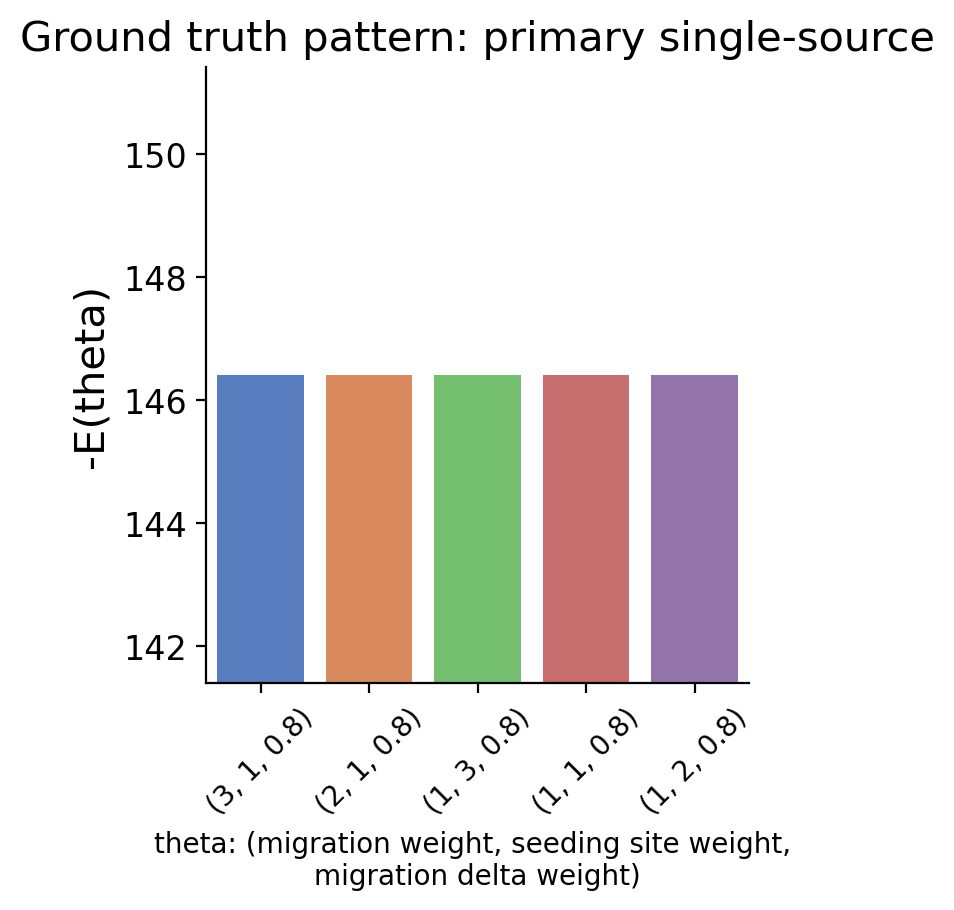


unique weights {(2, 1, 0.8), (3, 1, 0.8), (1, 3, 0.8), (1, 1, 0.8), (1, 2, 0.8)}
total patients 7825
BEST THETA (1, 1, 0.8) BEST CROSS ENT tensor(-2380.1560)
all_theta_to_cross_ent_sum {(2, 1, 0.8): tensor(-2394.6875), (3, 1, 0.8): tensor(-2425.7004), (1, 3, 0.8): tensor(-2468.6116), (1, 1, 0.8): tensor(-2380.1560), (1, 2, 0.8): tensor(-2411.1636)}
[(2, 1, 0.8), (3, 1, 0.8), (1, 3, 0.8), (1, 1, 0.8), (1, 2, 0.8)] ['(3, 1, 0.8)', '(2, 1, 0.8)', '(1, 3, 0.8)', '(1, 1, 0.8)', '(1, 2, 0.8)'] [2425.700439453125, 2394.6875, 2468.611572265625, 2380.156005859375, 2411.16357421875]


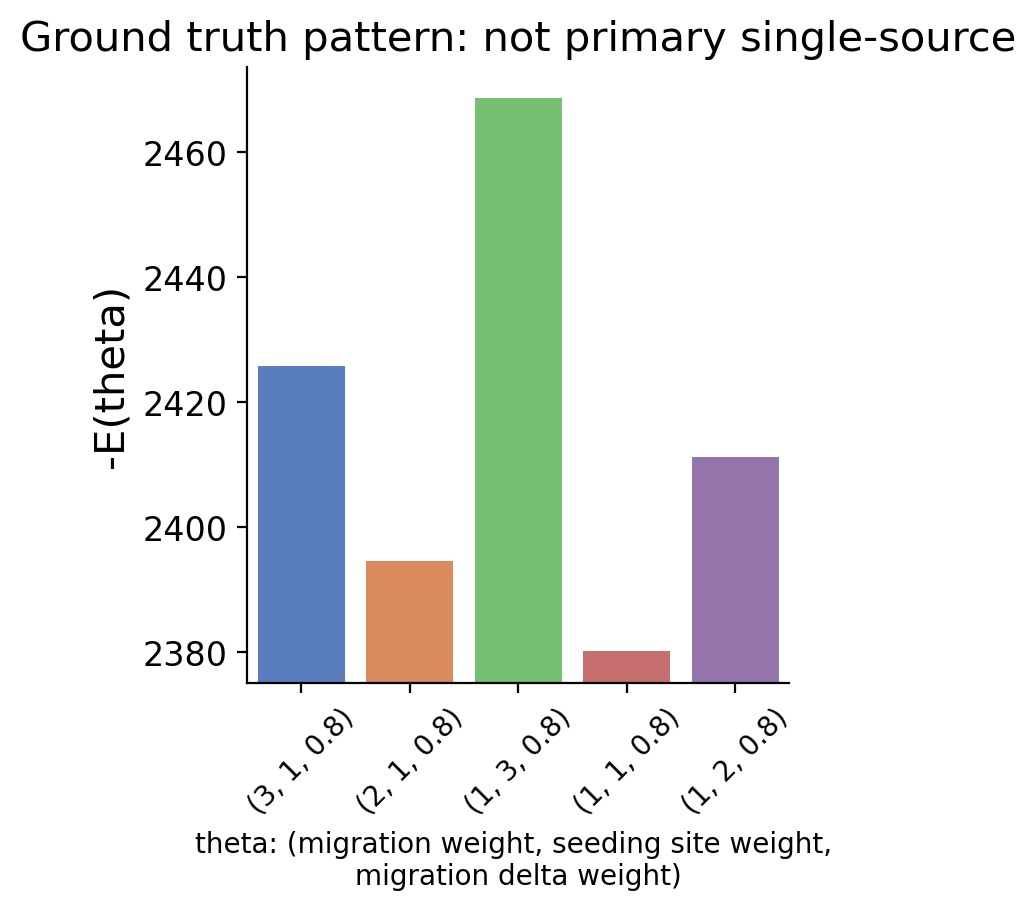


unique weights {(0.9, 0.1, 0.8), (0.25, 0.75, 0.8), (0.1, 0.9, 0.8), (0.75, 0.25, 0.8), (0.5, 0.5, 0.8)}


KeyboardInterrupt: 

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import fnmatch


SITES = ["m5", "m8"]
MIG_TYPES = ["mS", "M", "S", "R"]
types_map = {"mS":"single-source", "M":"multi-source", "S":"single-source", "R":"reseeding"}

DATE = "12032023"
PARAMS = "bs1024_calibrate_wip_nosolvepoly_3,2,1,1,1_1,1,1,2,3"

def is_ground_truth_tree_parallel_single_source(site, mig_type, seed):
    labeling_fn = os.path.join(SIMS_DIR, site, mig_type, f"T_seed{seed}.vertex.labeling")
    tree_fn = os.path.join(SIMS_DIR, site, mig_type, f"T_seed{seed}.tree")
    true_edges, true_mig_edges, true_labeling = eutil.parse_clone_tree(tree_fn, labeling_fn)
    del true_labeling['GL']
    num_nodes = len(true_labeling)
    num_sites = len(set(list(true_labeling.values())))
    node_label_to_idx = {k:i for i,k in enumerate(list(true_labeling.keys()))}
    A = torch.zeros((num_nodes, num_nodes))
    for edge in true_edges:
        if edge[0] == "GL":
            continue
        A[node_label_to_idx[edge[0]], node_label_to_idx[edge[1]]] = 1
    
    site_label_to_idx = {k:i for i,k in enumerate(set(list(true_labeling.values())))}
    V = torch.zeros((num_sites, num_nodes))
    for node_label in true_labeling:
        site_label = true_labeling[node_label]
        V[site_label_to_idx[site_label], node_label_to_idx[node_label]] = 1
    
    m, c, s, _, _ = get_ancestral_labeling_metrics(add_batch_dim(V), A, None, None, None)    
    return s.item()==1.0

def plot_seaborn_bar_chart(data_dict, pattern):
    fig = plt.figure(figsize=(3.5, 4),dpi=200)
    
    keys = list(data_dict.keys())
    sorted_keys = sorted(keys, key=lambda x: x[0], reverse=True)
    string_keys = [str((k)) for k in sorted_keys]
    values = [-1*data_dict[k].item() for k in sorted_keys]
    print(keys, string_keys, values)
    snsfig = sns.barplot(x=string_keys, y=values, palette=sns.color_palette("muted"),
                         order=string_keys)
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)

    plt.title(f"Ground truth pattern: {pattern}",fontsize=15)
    plt.xlabel("Theta: (migration weight, seeding site weight, \nmigration delta weight)",fontsize=10)
    plt.ylabel("-E(theta)",fontsize=15)
    plt.xticks(fontsize=10, rotation=45)
    plt.yticks(fontsize=12)
    plt.ylim(min(values)-5, max(values)+5)
    fig.savefig(os.path.join(REPO_DIR, "src/test/output_plots/", f"cross_ent_{pattern}_{PARAMS}_{DATE}.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 
    plt.show()
    plt.close()


PREDICTION_DIR = os.path.join(REPO_DIR, f"src/test/machina_simulated_data/", f'predictions_{PARAMS}_{DATE}')

parallel_ss_trees = []
nonparallel_ss_trees = []
mig_type_to_trees = {m:[] for m in MIG_TYPES}

for mig_type in MIG_TYPES:
    for site in SITES:
        site_mig_type_dir = os.path.join(SIMS_DIR, site, mig_type)
        seeds = fnmatch.filter(os.listdir(site_mig_type_dir), 'clustering_observed_seed*.txt')
        seeds = [s.replace(".txt", "").replace("clustering_observed_seed", "") for s in seeds]
        for seed in seeds:
            is_parallel_ss = is_ground_truth_tree_parallel_single_source(site, mig_type, seed)
            num_trees = get_num_mut_trees(os.path.join(SIMS_DIR, f"{site}_mut_trees", f"mut_trees_{mig_type}_seed{seed}.txt"))
            for tree_num in range(num_trees):
                seeding_fn = os.path.join(PREDICTION_DIR, site, mig_type, f"tree{tree_num}_seed{seed}.pkl.gz")
                if is_parallel_ss:
                    parallel_ss_trees.append(seeding_fn) 
                else:
                    nonparallel_ss_trees.append(seeding_fn)
                mig_type_to_trees[mig_type].append(seeding_fn)
# print(len(parallel_ss_trees),len(nonparallel_ss_trees)) 
unique_weights = [(0.9, 0.1, 0.8), (0.75, 0.25, 0.8), (0.5, 0.5, 0.8), (0.25, 0.75, 0.8), (0.1, 0.9, 0.8)]

for pckl_filenames, title in zip([parallel_ss_trees, nonparallel_ss_trees], ["primary single-source", "not primary single-source"]):
    best_theta, best_cross_ent, all_theta_to_cross_ent_sum = eutil.get_argmax_cross_ent_thetas(pickle_file_list=pckl_filenames, weights=unique_weights)
    print("BEST THETA", best_theta, "BEST CROSS ENT", best_cross_ent)
    print("all_theta_to_cross_ent_sum", all_theta_to_cross_ent_sum)
    plot_seaborn_bar_chart(all_theta_to_cross_ent_sum, title)
    print()

for mig_type in mig_type_to_trees:
    best_theta, best_cross_ent, all_theta_to_cross_ent_sum = eutil.get_argmax_cross_ent_thetas(pickle_file_list=mig_type_to_trees[mig_type], weights=unique_weights)
    print("BEST THETA", best_theta, "BEST CROSS ENT", best_cross_ent)
    print("all_theta_to_cross_ent_sum", all_theta_to_cross_ent_sum)
    plot_seaborn_bar_chart(all_theta_to_cross_ent_sum, mig_type)
    print()
        

In [23]:
import fnmatch
import pandas as pd

x = 0
k = 5
LOSS_THRES = 0.0

mig_type_to_seeding_pattern_df = {}
mig_type_to_topk_seeding_pattern_df = {}
mig_type_to_topk_seeding_pattern_counts_df = {}
mig_type_to_consensus_pattern = {}
mig_type_to_top_pattern = {}
gt_mig_type_to_pred_type_to_avg_gen_loss = {}

PREDICTION_DIR = os.path.join(REPO_DIR, f"src/test/machina_simulated_data/", f'predictions_{PARAMS}_{DATE}')
for mig_type in MIG_TYPES:
    for site in SITES:
        print(site, mig_type)
        # Get all seeds for mig_type + site combo
        site_mig_type_dir = os.path.join(SIMS_DIR, site, mig_type)
        seeds = fnmatch.filter(os.listdir(site_mig_type_dir), 'clustering_observed_seed*.txt')
        seeds = [s.replace(".txt", "").replace("clustering_observed_seed", "") for s in seeds]
        for seed in seeds:
            num_trees = get_num_mut_trees(os.path.join(SIMS_DIR, f"{site}_mut_trees", f"mut_trees_{mig_type}_seed{seed}.txt"))
            consensus_patterns_losses = []
            for tree_num in range(num_trees):
                seeding_fn = os.path.join(PREDICTION_DIR, site, mig_type, f"tree{tree_num}_seed{seed}_eval_loss_by_seeding_pattern.txt")
                seeding_df = pd.read_csv(seeding_fn, sep=',')
                seeding_df['Overall Pattern'] = seeding_df.apply(lambda row: get_overall_pattern(row), axis=1)
                seeding_df['Tree'] = [f"{mig_type}_{site}_{seed}_{tree_num}" for _ in range(len(seeding_df))]
                sort_seeding_df = seeding_df.sort_values(by='Evaluation loss', ascending=True).head(k)
                pred_pattern_eval_averages = seeding_df.groupby('Overall Pattern')['Evaluation loss'].mean().to_dict()

                topk_counts_df = sort_seeding_df['Seeding pattern'].value_counts().to_frame().reset_index()
                mapped_type = types_map[mig_type]
                topk_patterns = topk_counts_df['Seeding pattern'].tolist()
                
                if mapped_type not in mig_type_to_seeding_pattern_df:
                    mig_type_to_seeding_pattern_df[mapped_type] = seeding_df
                    mig_type_to_topk_seeding_pattern_df[mapped_type] = sort_seeding_df
                    mig_type_to_topk_seeding_pattern_counts_df[mapped_type] = topk_counts_df
                    mig_type_to_consensus_pattern[mapped_type] = []
                    mig_type_to_top_pattern[mapped_type] = []
                    gt_mig_type_to_pred_type_to_avg_gen_loss[mapped_type] = []
                else:
                    mig_type_to_seeding_pattern_df[mapped_type] = pd.concat([mig_type_to_seeding_pattern_df[mapped_type], seeding_df], axis=0)
                    mig_type_to_topk_seeding_pattern_df[mapped_type] = pd.concat([mig_type_to_topk_seeding_pattern_df[mapped_type], sort_seeding_df], axis=0)
                    mig_type_to_topk_seeding_pattern_counts_df[mapped_type] = pd.concat([mig_type_to_topk_seeding_pattern_counts_df[mapped_type], topk_counts_df], axis=0)
                    
                gt_mig_type_to_pred_type_to_avg_gen_loss[mapped_type].append(pred_pattern_eval_averages)
                mig_type_to_top_pattern[mapped_type].append(sort_seeding_df.head(1)['Seeding pattern'].item())
                
                consensus_fn = os.path.join(PREDICTION_DIR, site, mig_type, f"tree{tree_num}_seed{seed}_consensus_pattern.txt")
                with open(consensus_fn, 'r') as f:
                    for line in f:
                        items = line.strip().split(";")
                        pred_pattern = items[0]
                        pred_pattern_loss = items[1]
                        mig_type_to_consensus_pattern[mapped_type].append(pred_pattern)
                        consensus_patterns_losses.append((pred_pattern, pred_pattern_loss))
                if (mapped_type == 'single-source' and 'single-source' not in pred_pattern):
                    print(f"single-source mistaken as {pred_pattern}", site, mig_type, seed, tree_num)
                if (mapped_type == 'multi-source' and 'multi-source' not in pred_pattern):
                    print(f"multi-source mistaken as {pred_pattern}", site, mig_type, seed, tree_num)
                        
                x += 1
                
            best_trees = eutil.get_metient_min_loss_trees(os.path.join(PREDICTION_DIR, site, mig_type), seed, float("inf"), loss_thres=LOSS_THRES)
            for i, (loss, results_dict, met_tree_num) in enumerate(best_trees):
                if mapped_type not in mig_type_to_top_pattern:
                    mig_type_to_top_pattern[mapped_type] = []
                V = results_dict[OUT_LABElING_KEY][met_tree_num]
                A = results_dict[OUT_ADJ_KEY][met_tree_num]
                mig_type_to_top_pattern[mapped_type].append(putil.get_seeding_pattern(V,A))
                
assert(x==1647)


m5 mS
# min loss trees: 1
# min loss trees: 1
# min loss trees: 3
# min loss trees: 1
# min loss trees: 1
# min loss trees: 1
# min loss trees: 2
# min loss trees: 1
# min loss trees: 1
# min loss trees: 1
m8 mS
# min loss trees: 1
# min loss trees: 1


FileNotFoundError: [Errno 2] No such file or directory: '/lila/data/morrisq/divyak/projects/met_history_prediction/src/jupyter_notebooks/../../src/test/machina_simulated_data/predictions_bs1024_calibrate_wip_1000,1_1,1000_solvepoly_newfilterandhash_11292023/m8/mS/tree6_seed4_eval_loss_by_seeding_pattern.txt'

### What is the distribution of genetic distance scores for each seeding pattern?

ground truth: single-source


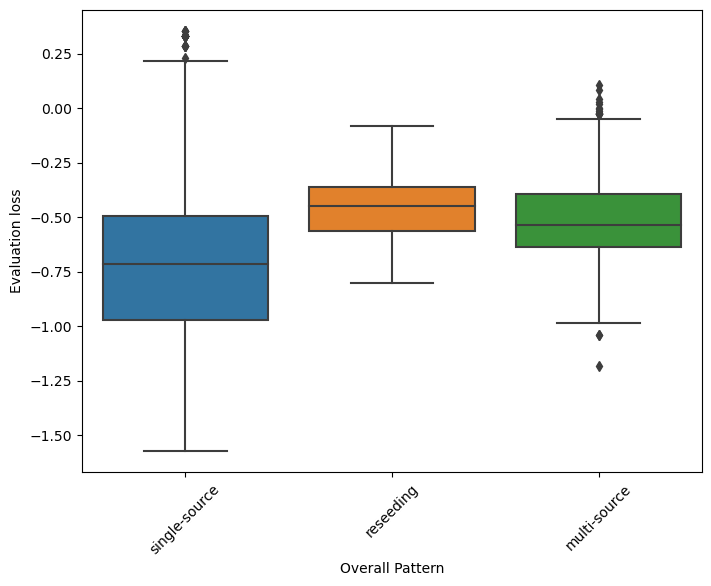

ground truth: multi-source


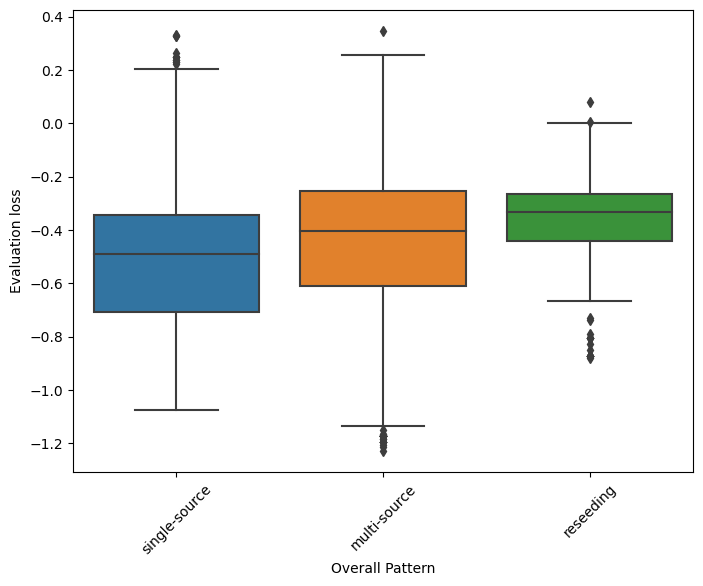

ground truth: reseeding


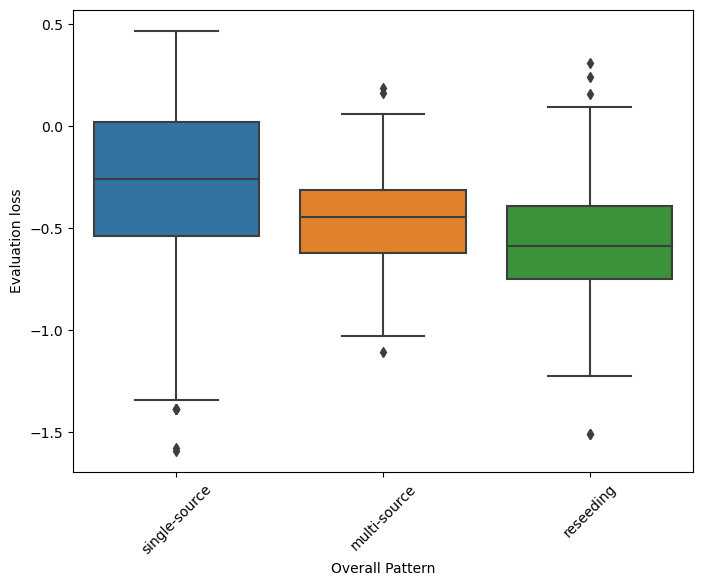

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
box_pairs = [("single-source", "multi-source"), ("single-source", "reseeding"), ("multi-source", "reseeding")]
for mig_type in mig_type_to_seeding_pattern_df:
    print("ground truth:",mig_type)
    mig_type_to_seeding_pattern_df[mig_type]['Overall Pattern'] = mig_type_to_seeding_pattern_df[mig_type].apply(lambda row: get_overall_pattern(row), axis=1)

    plt.figure(figsize=(8, 6))  # Optional: Set the size of the plot
    
    snsfig = sns.boxplot(x='Overall Pattern', y='Evaluation loss', data=mig_type_to_seeding_pattern_df[mig_type])
#     add_stat_annotation(snsfig, data=mig_type_to_seeding_pattern_df[mig_type], x='Overall Pattern', y='Evaluation loss',
#                     box_pairs=box_pairs, test='t-test_welch', text_format='star', loc='inside', verbose=1, fontsize=18, comparisons_correction=None)

    plt.xticks(rotation=45)
    plt.show()

### What is the genetic distance score of the top k solutions (by genetic distance score) for each seeding pattern?

ground truth: single-source
[('single-source', 'multi-source'), ('single-source', 'reseeding')]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

single-source v.s. multi-source: Welch's t-test independent samples, P_val=1.989e-113 stat=-2.379e+01
single-source v.s. reseeding: Welch's t-test independent samples, P_val=7.284e-62 stat=-2.234e+01


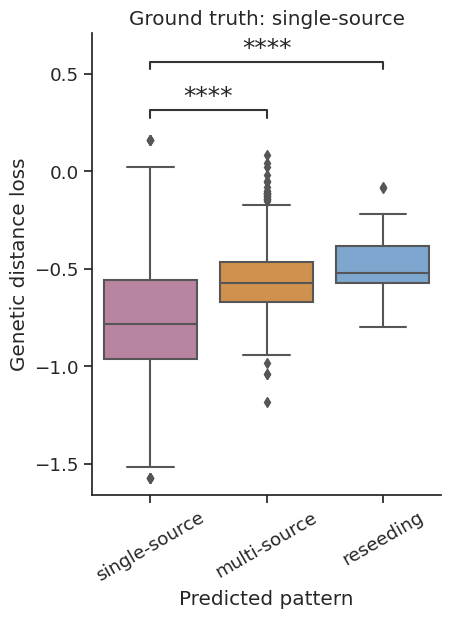

ground truth: multi-source
[('multi-source', 'single-source'), ('multi-source', 'reseeding')]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

single-source v.s. multi-source: Welch's t-test independent samples, P_val=1.075e-08 stat=-5.799e+00
multi-source v.s. reseeding: Welch's t-test independent samples, P_val=9.963e-03 stat=-2.589e+00


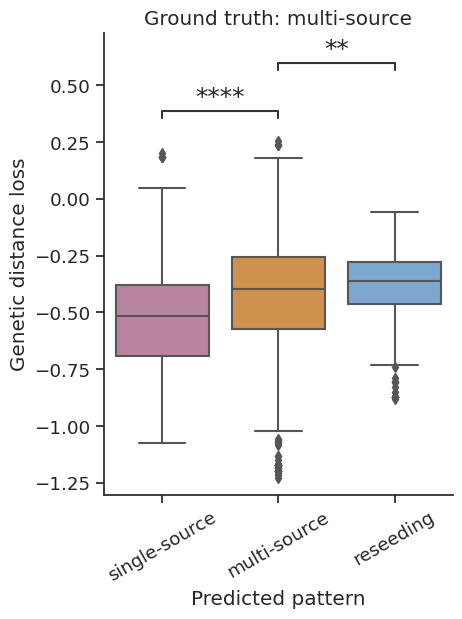

ground truth: reseeding
[('reseeding', 'single-source'), ('reseeding', 'multi-source')]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

multi-source v.s. reseeding: Welch's t-test independent samples, P_val=2.114e-14 stat=7.958e+00
single-source v.s. reseeding: Welch's t-test independent samples, P_val=1.900e-23 stat=1.015e+01


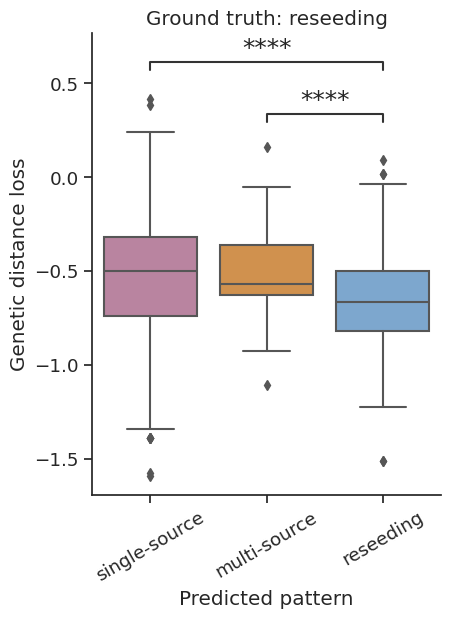

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

order = ["single-source", "multi-source", "reseeding"]
for mig_type in mig_type_to_seeding_pattern_df:
    print("ground truth:",mig_type)
    mig_type_to_topk_seeding_pattern_df[mig_type]['Overall Pattern'] = mig_type_to_topk_seeding_pattern_df[mig_type].apply(lambda row: get_overall_pattern(row), axis=1)
    sns.set(font_scale=1.2)
    sns.set_style("whitegrid")
    sns.set_style("ticks")
    sns.set_palette(sns.color_palette(["#c27ba0", "#e69138", "#6fa8dc"]))

    plt.figure(figsize=(4.5, 6))  # Optional: Set the size of the plot
    snsfig = sns.boxplot(x='Overall Pattern', y='Evaluation loss', data=mig_type_to_topk_seeding_pattern_df[mig_type], order=order)
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)

    box_pairs = []    
    for other_pattern in mig_type_to_seeding_pattern_df:
        if mig_type != other_pattern:
            box_pairs.append((mig_type, other_pattern))
    print(box_pairs)
    add_stat_annotation(snsfig, data=mig_type_to_topk_seeding_pattern_df[mig_type], x='Overall Pattern', y='Evaluation loss',order=order,
                        box_pairs=box_pairs, test='t-test_welch', text_format='star', loc='inside', verbose=1, fontsize=18, comparisons_correction=None)

    plt.title(f"Ground truth: {mig_type}")
    plt.ylabel("Genetic distance loss")
    plt.xlabel("Predicted pattern")
    plt.xticks(rotation=30)
    plt.savefig(os.path.join(REPO_DIR, "src/test/output_plots", f"ground_truth_{mig_type}_eval_loss_boxplot.png"), dpi=600, bbox_inches='tight', pad_inches=0.5)
    plt.show()
    plt.close()

### What do the scores look like when you compare the scores for the ground truth pattern to all other patterns?

ground truth: single-source


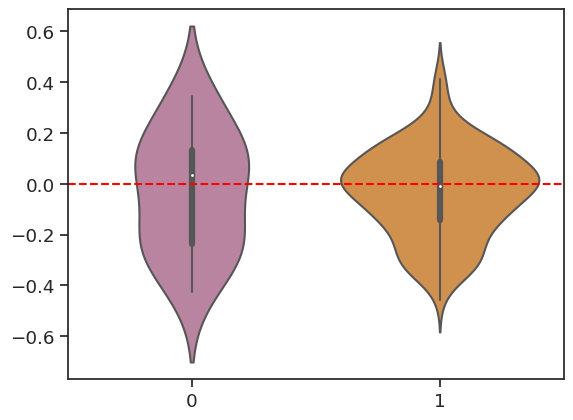

ground truth: multi-source


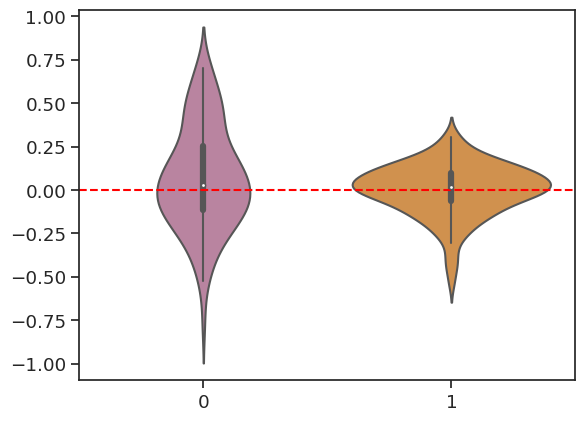

ground truth: reseeding


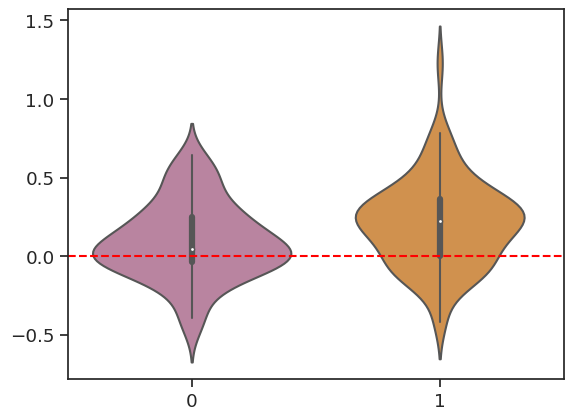

In [8]:
order = ["single-source", "multi-source", "reseeding"]
for gt_type in mig_type_to_seeding_pattern_df:
    print("ground truth:",gt_type)
    pred_pattern_to_avg_score_list = gt_mig_type_to_pred_type_to_avg_gen_loss[gt_type]

    other_pattern_to_residuals = {}
    ys = []
    for pred_tree in pred_pattern_to_avg_score_list:
        #print(pred_tree)
        if gt_type not in pred_tree:
            continue
        correct_pattern_score = pred_tree[gt_type]
        for pred_pattern in pred_tree:
            if pred_pattern != gt_type:
                if pred_pattern not in other_pattern_to_residuals:
                    other_pattern_to_residuals[pred_pattern] = []
                other_pattern_to_residuals[pred_pattern].append(pred_tree[pred_pattern]-correct_pattern_score)
                ys.append(pred_tree[pred_pattern]-correct_pattern_score)
    
    xs = [x for x in range(len(ys))]
#     assert(len(xs)+len(ys) == len(df))
    #sns.scatterplot(x=xs, y=ys)
    keys = list(other_pattern_to_residuals.keys())
    vals = list(other_pattern_to_residuals.values())
    sns.violinplot(vals)
    plt.axhline(y=0, color='red', linestyle='--', label='y = 0')


    plt.show()
    plt.close()


### What percent of the top k solutions (by genetic distance score) belong to each seeding pattern?

ground truth: single-source


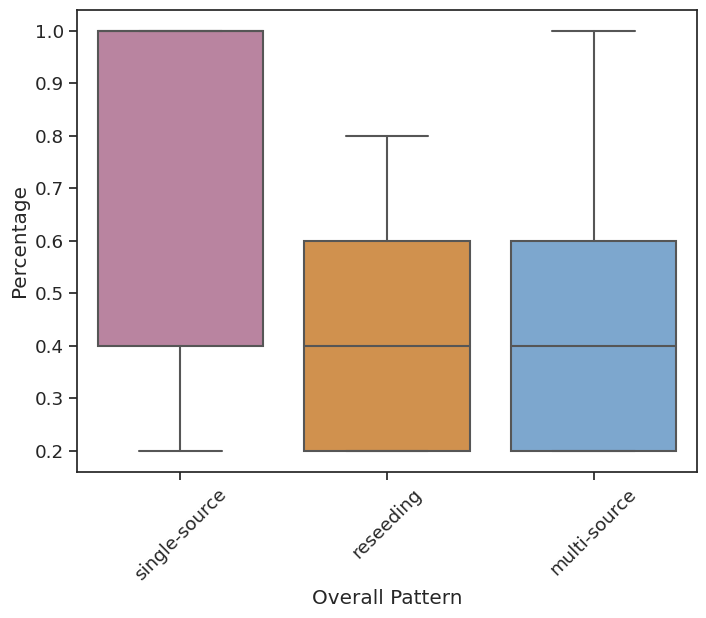

ground truth: multi-source


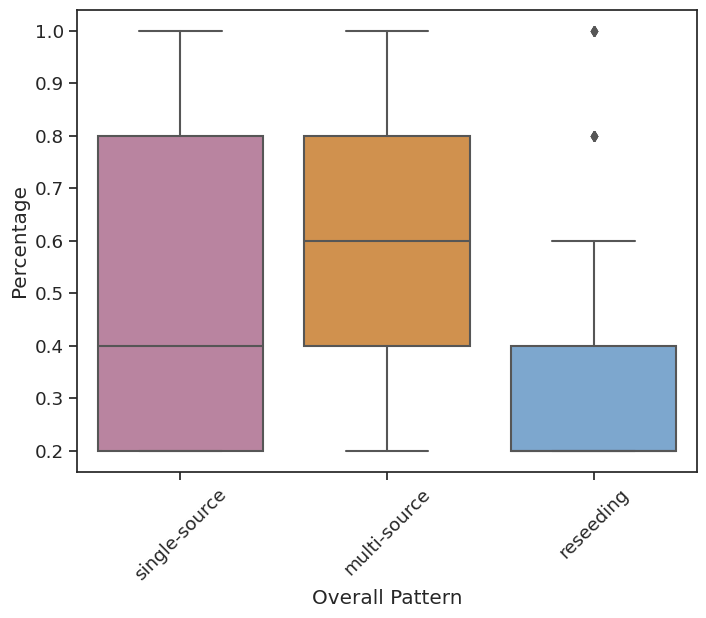

ground truth: reseeding


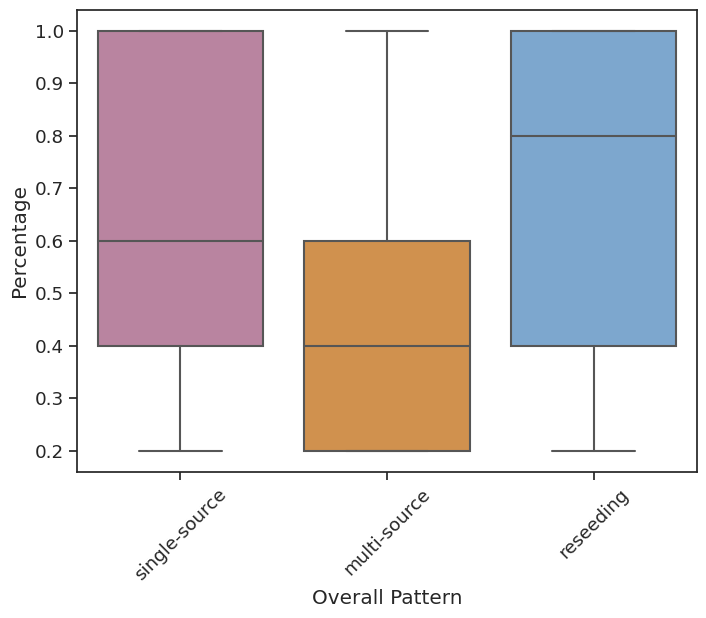

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


for mig_type in mig_type_to_seeding_pattern_df:
    print("ground truth:",mig_type)
    df = mig_type_to_topk_seeding_pattern_counts_df[mig_type]

    df['Overall Pattern'] = df.apply(lambda row: get_overall_pattern(row), axis=1)
    df['Percentage'] = df.apply(lambda row: row['count']/float(k), axis=1)

    plt.figure(figsize=(8, 6))  # Optional: Set the size of the plot
    sns.boxplot(x='Overall Pattern', y='Percentage', data=df)
    plt.xticks(rotation=45)
    plt.show()

In [10]:
for pattern in mig_type_to_topk_seeding_pattern_counts_df:
    print("ground truth:", pattern)
    df = mig_type_to_topk_seeding_pattern_counts_df[pattern]
    print(df)
    grouped_df = df.groupby(['Overall Pattern'])['count'].sum()
    print(grouped_df)
    #sns.stripplot(data=grouped_df, x='Cell_Type', y='Fraction', hue='Marker', jitter=True, size=10, palette='Reds')


ground truth: single-source
                     Seeding pattern  count Overall Pattern  Percentage
0   monoclonal single-source seeding      5   single-source       1.000
0   monoclonal single-source seeding      5   single-source       1.000
0   monoclonal single-source seeding      5   single-source       1.000
0   monoclonal single-source seeding      5   single-source       1.000
0   monoclonal single-source seeding      5   single-source       1.000
..                               ...    ...             ...         ...
0   polyclonal single-source seeding      5   single-source       1.000
0   polyclonal single-source seeding      3   single-source       0.600
0   polyclonal single-source seeding      2   single-source       0.400
0   polyclonal single-source seeding      5   single-source       1.000
0   polyclonal single-source seeding      4   single-source       0.800

[976 rows x 4 columns]
Overall Pattern
multi-source      874
reseeding         138
single-source    1972
Na

### What is the confusion matrix for the top seeding pattern?

In [11]:
def confusion_matrix(cm, title, output_name):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", cbar=True,)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

['single-source', 'multi-source', 'reseeding']
ground truth: single-source
Overall Pattern
single-source    1972
multi-source      874
reseeding         138
Name: count, dtype: int64
ground truth: multi-source
Overall Pattern
multi-source     1293
single-source     384
reseeding         218
Name: count, dtype: int64
ground truth: reseeding
Overall Pattern
single-source    1124
reseeding         557
multi-source      180
Name: count, dtype: int64


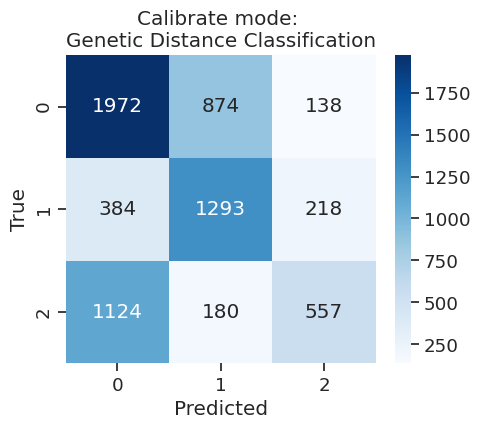

In [17]:
import numpy as np
patterns = [k for k in mig_type_to_top_pattern]
print(patterns)
cm = np.zeros((len(patterns), len(patterns)))
for i,gt_pattern in enumerate(patterns):
    print("ground truth:", gt_pattern)
    pred_df = pd.DataFrame(mig_type_to_topk_seeding_pattern_df[gt_pattern]['Overall Pattern'], columns=["Overall Pattern"])
    #pred_df = pd.DataFrame(mig_type_to_top_pattern[gt_pattern], columns=["Seeding pattern"])
    #pred_df['Overall Pattern'] = pred_df.apply(lambda row: get_overall_pattern(row), axis=1)
    counts_df = pred_df['Overall Pattern'].value_counts()
    print(counts_df)
    for j,pred_pattern in enumerate(patterns):
        cm[i,j] = counts_df[pred_pattern]
confusion_matrix(cm, "Calibrate mode: \nGenetic Distance Classification", f"top_seeding_pattern_by_gd_eval_loss_{PARAMS}")
                 

### What is the confusion matrix in evaluate mode?

In [13]:
import joblib
import glob
import gzip


def get_top_seeding_patterns_eval_mode(predictions_dir, k):
    eval_mode_mig_type_to_top_seeding_pattern = {}
    for mig_type in MIG_TYPES:
        for site in SITES:
            print(site, mig_type)
            site_mig_type_dir = os.path.join(SIMS_DIR, site, mig_type)
            seeds = fnmatch.filter(os.listdir(site_mig_type_dir), 'clustering_observed_seed*.txt')
            seeds = [s.replace(".txt", "").replace("clustering_observed_seed", "") for s in seeds]
            for seed in seeds:
                tree_pickles = glob.glob(os.path.join(predictions_dir, site, mig_type, f"*_seed{seed}.pkl.gz"))
                for tree_pickle in tree_pickles:

                    with gzip.open(tree_pickle,'rb') as f:
                        results_dict = joblib.load(f)
                    num_solutions = len(results_dict[OUT_LABElING_KEY])
                    n = num_solutions if num_solutions < k else k
                    for i in range(n):
                        V = results_dict[OUT_LABElING_KEY][i]
                        A = results_dict[OUT_ADJ_KEY][i]

                        mapped_type = types_map[mig_type]
                        if mapped_type not in eval_mode_mig_type_to_top_seeding_pattern:
                            eval_mode_mig_type_to_top_seeding_pattern[mapped_type] = []
                        top_pattern = putil.get_seeding_pattern(V,A)
                        eval_mode_mig_type_to_top_seeding_pattern[mapped_type].append(top_pattern)

    patterns = [k for k in eval_mode_mig_type_to_top_seeding_pattern]
    print(patterns)
    cm = np.zeros((len(patterns), len(patterns)))
    for i,gt_pattern in enumerate(patterns):
        print("ground truth:", gt_pattern)
        pred_df = pd.DataFrame(eval_mode_mig_type_to_top_seeding_pattern[gt_pattern], columns=["Seeding pattern"])
        pred_df['Overall Pattern'] = pred_df.apply(lambda row: get_overall_pattern(row), axis=1)
        counts_df = pred_df['Overall Pattern'].value_counts()
        print(counts_df)
        for j,pred_pattern in enumerate(patterns):
            cm[i,j] = counts_df[pred_pattern]
    return cm

m5 mS
m8 mS
m5 M
m8 M
m5 S
m8 S
m5 R
m8 R
['single-source', 'multi-source', 'reseeding']
ground truth: single-source
Overall Pattern
single-source    1094
multi-source      547
reseeding         256
Name: count, dtype: int64
ground truth: multi-source
Overall Pattern
multi-source     942
single-source    116
reseeding         63
Name: count, dtype: int64
ground truth: reseeding
Overall Pattern
single-source    689
reseeding        371
multi-source     111
Name: count, dtype: int64


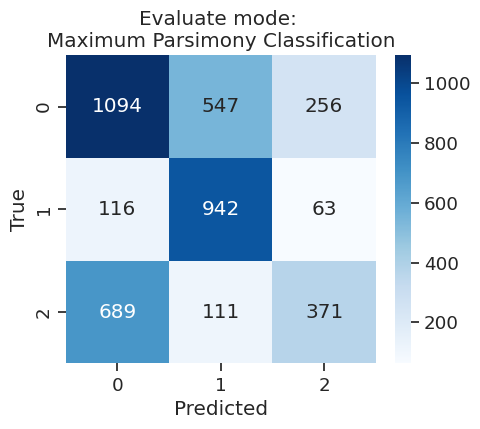

In [18]:
# Evaluate mode, maximum parsimony only
EVAL_MP_PARAMS = "bs1024_evaluate_solvepoly_wip_11152023"
k = 5
eval_mode_no_gd_dir = os.path.join(REPO_DIR, f"src/test/machina_simulated_data/predictions_{EVAL_MP_PARAMS}")
cm = get_top_seeding_patterns_eval_mode(eval_mode_no_gd_dir, k)
confusion_matrix(cm, "Evaluate mode: \nMaximum Parsimony Classification", f"top_seeding_pattern_by_mp_{EVAL_MP_PARAMS}")


m5 mS
m8 mS
m5 M
m8 M
m5 S
m8 S
m5 R
m8 R
['single-source', 'multi-source', 'reseeding']
ground truth: single-source
Overall Pattern
single-source    1057
multi-source      511
reseeding         255
Name: count, dtype: int64
ground truth: multi-source
Overall Pattern
multi-source     976
single-source    113
reseeding         67
Name: count, dtype: int64
ground truth: reseeding
Overall Pattern
single-source    670
reseeding        368
multi-source      99
Name: count, dtype: int64


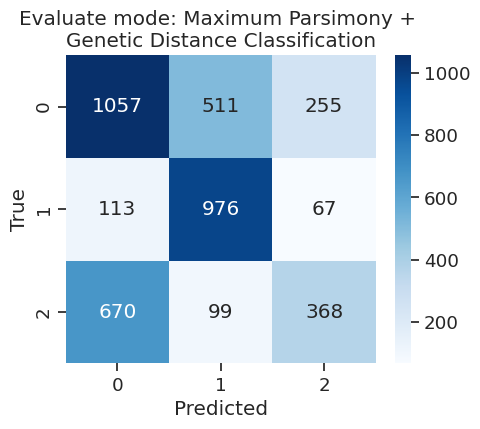

In [19]:
# Evaluate mode, maximum parsimony and genetic distance
EVAL_MPGD_PARAMS = "bs1024_evaluate_solvepoly_gd_wip_11152023"
k = 5
eval_mode_no_gd_dir = os.path.join(REPO_DIR, f"src/test/machina_simulated_data/predictions_{EVAL_MPGD_PARAMS}")
cm = get_top_seeding_patterns_eval_mode(eval_mode_no_gd_dir, k)
confusion_matrix(cm, "Evaluate mode: Maximum Parsimony + \nGenetic Distance Classification", f"top_seeding_pattern_by_mp_gd_{EVAL_MPGD_PARAMS}")
